In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn

In [21]:
FIG_SIZE = (7, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-09-30')
REL_CENSOR = pd.to_datetime('2018-10-16')  # Limited public beta of GHA

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

In [22]:
RE_SEMVER = r'^(?:(?:v|V)\.?)?(?P<major>\d{1,7})(?:\.(?P<minor>\d+)(?:\.(?P<patch>\d+))?)?(?P<misc>.*)$'
RE_DATE = r'^\d{8}(?:[0-9:]*)$' 
RE_SHA = r'^[a-zA-Z0-9]{8}(?:[a-zA-Z0-9]{32})?$'

## Load data

In [23]:
df_releases = (
    pd.read_csv('../data/releases.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date, errors='coerce').dt.tz_convert(None))
    [lambda d: d.date.between(REL_CENSOR, pd.to_datetime('2022-08-31'), inclusive='both')]
    # Detect versioning scheme
    .assign(components=lambda d: d.release.str.match(RE_SEMVER))
    .assign(datebased=lambda d: d.release.str.match(RE_DATE))
    .assign(sha=lambda d: d.release.str.match(RE_SHA))
    .assign(other=True)
    .assign(versioning=lambda d: d[['datebased', 'sha', 'components', 'other']].idxmax(axis=1))
    # Detect number of components for semver
    .assign(versioning=lambda d: np.where(d.versioning == 'components', (d.release.str.count('\d+\.') + 1).fillna(0).astype(int).astype(str) + ' components', d.versioning))
    .replace({'versioning': {'1 components': '1 component', 'datebased': 'date', '4 components': '4+ components', '5 components': '4+ components'}})
    .drop(columns=['components', 'datebased', 'sha', 'other'])
)

In [24]:
df_snapshots = (
    pd.read_csv('../data/workflow_files.csv.gz', parse_dates=['date'])
    [['repository', 'date', 'filename', 'workflow']]
)

In [25]:
df_steps = (
    pd.read_csv('../data/steps.csv.gz')
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(anchor=lambda d: d.uses.str.split('@', n=1).str[1])
    # Detect versioning scheme
    .assign(components=lambda d: d.anchor.str.match(RE_SEMVER))
    .assign(date=lambda d: d.anchor.str.match(RE_DATE))
    .assign(sha=lambda d: d.anchor.str.match(RE_SHA))
    .assign(other=True)
    .fillna({'components': False, 'date': False, 'sha': False})
    .assign(versioning=lambda d: d[['date', 'sha', 'components', 'other']].idxmax(axis=1))
    # Detect number of components for semver
    .assign(versioning=lambda d: np.where(d.versioning == 'components', (d.anchor.str.count('\d+\.').fillna(0) + 1).astype(int).astype(str) + ' components', d.versioning))
    .replace({'versioning': {'1 components': '1 component', '4 components': '4+ components', '5 components': '4+ components'}})
)

How many steps are relying on an Action for which we have releases?

In [26]:
len(
    df_steps
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0])
    [['workflow', 'action']]
    [lambda d: d.action.isin(
        df_releases.assign(action=lambda d: d.owner + '/' + d.repo)['action']
    )]
    .merge(
        df_snapshots[['workflow']],
        how='right',
    )
)

3694362

## Versioning practices for Actions

### Monthly proportion of releases for each versioning practice

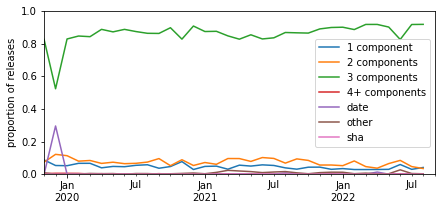

In [27]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(releases=('release', 'count'))
    .unstack()['releases']
    .fillna(0).astype(int)
    .groupby(pd.Grouper(level=0, freq='M'))
    .first()
    .apply(lambda s: s / s.sum(), axis=1)
    .loc[DATE_RANGE[0]:DATE_RANGE[1]]
)

temp.plot(ax=ax, color=PALETTE, )
ax.legend(title=None)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

savefig(fig, 'version_monthly_releases')

In [28]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
versioning,,,,,,,,
1 component,34.0,0.046223,0.014739,0.028497,0.031704,0.046454,0.054265,0.087479
2 components,34.0,0.074036,0.020989,0.034794,0.057414,0.073658,0.087683,0.121739
3 components,34.0,0.861353,0.066757,0.523913,0.844307,0.870848,0.896342,0.918814
4+ components,34.0,0.001399,0.001685,0.000000,0.000000,0.001106,0.002447,0.005435
date,34.0,0.009547,0.050620,0.000000,0.000000,0.000000,0.000708,0.295652
other,34.0,0.007400,0.006776,0.000000,0.002841,0.004426,0.010802,0.026746
sha,34.0,0.000041,0.000240,0.000000,0.000000,0.000000,0.000000,0.001399


versioning
1 component      0.041237
2 components     0.034794
3 components     0.918814
4+ components    0.002577
date             0.000000
other            0.002577
sha              0.000000
Name: 2022-08-31 00:00:00, dtype: float64

### Monthly proportion of Actions for each versioning practice

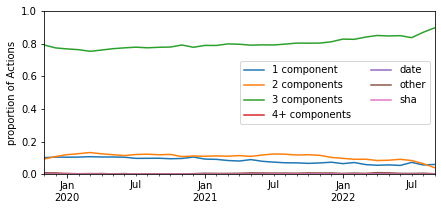

In [29]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_releases
    .assign(action=lambda d: d.owner + '/' + d.repo)
    .sort_values(['date', 'action'])
    .drop_duplicates(['date', 'action'], keep='last')
    # Fill the "gaps"
    .assign(date=lambda d: d.date + pd.offsets.DateOffset(months=1))
    .set_index('date')
    .groupby('action', as_index=False)
    .resample('M')
    .ffill()
    .reset_index()
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(actions=('action', 'count'))  # No duplicate so "count" == "nunique"
    .unstack()['actions']
    .fillna(0)
    .apply(lambda s: s / s.sum(), axis=1)
    .loc[DATE_RANGE[0]:DATE_RANGE[1]]
)

temp.plot(ax=ax)
ax.legend(title=None, ncol=2)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of Actions',
    ylim=(0, 1)
)

savefig(fig, 'version_monthly_actions')

In [30]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

               count      mean       std       min       25%       50%       75%       max
versioning                                                                                
1 component     35.0  0.083324  0.018108  0.053763  0.069307  0.083887  0.099749  0.107459
2 components    35.0  0.107106  0.019153  0.039886  0.094887  0.112295  0.119617  0.132743
3 components    35.0  0.801780  0.033220  0.753477  0.778297  0.792517  0.819441  0.897436
4+ components   35.0  0.001662  0.001337  0.000000  0.000843  0.001033  0.002015  0.005329
date            35.0  0.000812  0.000410  0.000000  0.000823  0.000890  0.000998  0.001555
other           35.0  0.005076  0.002503  0.000991  0.002830  0.005165  0.007052  0.009677
sha             35.0  0.000240  0.000415  0.000000  0.000000  0.000000  0.000425  0.001033


versioning
1 component      0.059829
2 components     0.039886
3 components     0.897436
4+ components    0.000000
date             0.000000
other            0.002849
sha              0.000000
Name: 2022-09-30 00:00:00, dtype: float64

## Versioning practices in workflows

### Monthly proportion of steps for each versioning practice

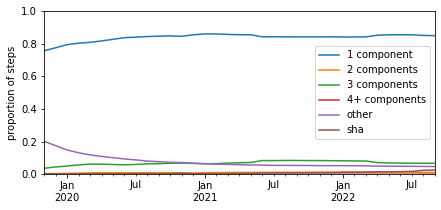

In [31]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps[['workflow', 'versioning']]
    .merge(
        df_snapshots,
        how='inner',
        on='workflow',
    )
    .groupby([pd.Grouper(key='date', freq='M'), 'versioning'])
    .agg(steps=('workflow', 'count'))  # We do not count workflows but steps
    .unstack()['steps']
    .fillna(0).astype(int)
    .groupby(pd.Grouper(level=0, freq='M'))
    .first()
    .apply(lambda s: s / s.sum(), axis=1)
)

temp.plot(ax=ax, color=PALETTE, )
ax.legend(title=None)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of steps',
    ylim=(0, 1),
)

savefig(fig, 'version_monthly_steps')

In [32]:
print(temp.describe().T.to_string())
display(temp.iloc[-1])

               count      mean       std       min       25%       50%       75%       max
versioning                                                                                
1 component     35.0  0.837827  0.023689  0.756514  0.840865  0.842539  0.853407  0.859958
2 components    35.0  0.010058  0.002433  0.003503  0.009059  0.010939  0.012053  0.012631
3 components    35.0  0.068454  0.011760  0.036348  0.062721  0.067212  0.081234  0.084233
4+ components   35.0  0.000018  0.000018  0.000000  0.000005  0.000011  0.000032  0.000057
other           35.0  0.075967  0.038019  0.047141  0.052364  0.058434  0.083854  0.201883
sha             35.0  0.007676  0.006229  0.001594  0.002995  0.005215  0.010774  0.025513


versioning
1 component      0.849535
2 components     0.010939
3 components     0.066867
4+ components    0.000005
other            0.047141
sha              0.025513
Name: 2022-09-30 00:00:00, dtype: float64